In [ ]:
!pip install -U torchtext==0.10.0

In [ ]:
!pip install pytorch-crf==0.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchtext.legacy.data import Field,NestedField, BucketIterator, Dataset, Example
from torchtext.vocab import Vocab
# from utils import read_file
from collections import Counter
import torch
from random import randint
# from augmentation import aug_replace_in_same_tag
import random

In [ ]:
def get_data(path):
    train_data = []
    with open(path, encoding='utf-8') as f:
        words = []
        tags = []
        for line in f:
            line = line.strip()
            if not line:
                train_data.append([words, tags])
                words = []
                tags = []
            else:
                columns = line.split(' ')
                words.append(columns[0])
                tags.append(columns[-1])
    return train_data

# nếu là số sẽ chuyển về 0, ví dụ covid-19 -> covid-00 hay 20-11-2001 -> 00-00-0000
def normalize_word(word):
    new_word = ""
    for char in word:
        if char.isdigit():
            new_word += '0'
        else:
            new_word += char
    return new_word

def read_file(path, data_fields, aug=False):
    # if aug:
    #     train_data = get_data(path)
    #     SYMPTOM_AND_DISEASE = get_instances_by_tag(train_data, 'SYMPTOM_AND_DISEASE')
    #     JOBS = get_instances_by_tag(train_data, 'JOB')

    with open(path, encoding='utf-8') as f:
        examples = []
        words = []
        tags = []
        for line in f:
            line = line.strip()
            if not line:
                examples.append(Example.fromlist([words, tags], data_fields))
                words = []
                tags = []
            else:
              columns = line.split(' ')
              words.append(columns[0])
              tags.append(columns[-1])

    return Dataset(examples, data_fields)

In [ ]:
class NerDataset:
    def __init__(self, train_path, val_path, test_path, batch_size, lower_word=True, wv_model=None, aug_train = True):
        self.word_field = Field(lower=lower_word)
        self.tag_field = Field(unk_token=None)

        self.char_nesting_field = Field(tokenize=list)
        self.char_field = NestedField(self.char_nesting_field)  # [batch_size, sent len, word len]
        self.data_fields = [(("word", "char"), (self.word_field, self.char_field)),
                            ("tag", self.tag_field)]

        self.train_dataset = read_file(train_path, self.data_fields, aug = aug_train)
        self.val_dataset = read_file(val_path, self.data_fields, aug = False)
        self.test_dataset = read_file(test_path, self.data_fields, aug = False)

        if wv_model:
            # retrieve word2vec model from gensim library
            # the file contains full word2vec model, not only key-vectors
            self.wv_model = wv_model
            self.embedding_dim = self.wv_model.vector_size
            # cannot create vocab with build_vocab(),
            # initiate vocab by building custom Counter based on word2vec model
            word_freq = {word: wv_model.get_vecattr(word, "count") for word in wv_model.index_to_key}
            word_counter = Counter(word_freq)
            self.word_field.vocab = Vocab(word_counter)
            # mapping each vector/embedding from word2vec model to word_field vocabs
            vectors = []
            for word, idx in self.word_field.vocab.stoi.items():
                if idx > 1:
                    vectors.append(torch.as_tensor(self.wv_model[word].tolist()))
                else:  # 0 is unk and 1 is pad
                    vectors.append(torch.zeros(self.embedding_dim))

            self.word_field.vocab.set_vectors(
                stoi=self.word_field.vocab.stoi,
                # list of vector embedding, orderred according to word_field.vocab
                vectors=vectors,
                dim=self.embedding_dim
            )

        else:
            self.word_field.build_vocab(self.train_dataset.word)

        self.tag_field.build_vocab(self.train_dataset.tag)
        self.char_field.build_vocab(self.train_dataset.char)

        self.train_iter, self.val_iter, self.test_iter = BucketIterator.splits(
            datasets=(self.train_dataset,
                      self.val_dataset,
                      self.test_dataset),
            batch_size=batch_size,
            sort=False)

        self.char_pad_idx = self.char_field.vocab.stoi[self.char_field.pad_token]
        self.word_pad_idx = self.word_field.vocab.stoi[self.word_field.pad_token]
        self.tag_pad_idx = self.tag_field.vocab.stoi[self.tag_field.pad_token]

In [ ]:
import torch
import torch.nn as nn
from torchcrf import CRF


class Embedding_layer(nn.Module):
    def __init__(self,
                 word_input_dim,
                 word_embedding_dim,
                 char_input_dim,
                 char_embedding_dim,
                 char_cnn_filter_num,
                 char_cnn_kernel_size,
                 word_pad_idx,
                 char_pad_idx,

                 char_emb_dropout,
                 word_emb_dropout,
                 cnn_dropout,

                 use_char = True):
        """
        :param word_input_dim: number of words in vocab, each word -> vector
        :param word_embedding_dim: dim of word embedding vector
        :param char_input_dim: number of characters in vocab
        :param char_embedding_dim: dim of char embedding vector
        :param char_cnn_filter_num:
        :param char_cnn_kernel_size:
        :param word_pad_idx:
        :param char_pad_idx:
        :param char_emb_dropout:
        :param word_emb_dropout:
        :param cnn_dropout:
        """
        super().__init__()
        self.word_pad_idx = word_pad_idx
        self.char_pad_idx = char_pad_idx
        self.word_embedding_dim = word_embedding_dim
        self.char_embedding_dim = char_embedding_dim
        self.use_char = use_char

        # LAYER 1A: Word Embedding
        self.word_embedding = nn.Embedding(
            num_embeddings=word_input_dim,
            embedding_dim=word_embedding_dim,
            padding_idx=word_pad_idx  # the entries at padding_idx do not contribute to the gradient
        )
        self.word_emb_dropout = nn.Dropout(word_emb_dropout)

        # LAYER 1B: Char Embedding-CNN
        self.char_embedding = nn.Embedding(
            num_embeddings=char_input_dim,
            embedding_dim=char_embedding_dim,
            padding_idx=char_pad_idx  # the entries at padding_idx do not contribute to the gradient
        )
        self.char_emb_dropout = nn.Dropout(char_emb_dropout)
        self.char_cnn = nn.Conv1d(
            in_channels=char_embedding_dim,
            out_channels=char_embedding_dim * char_cnn_filter_num,
            kernel_size=char_cnn_kernel_size,
            # groups=char_embedding_dim  # different 1d conv for each embedding dim
        )
        self.cnn_dropout = nn.Dropout(cnn_dropout)

    def forward(self, words, chars):
        """shape of input
        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # tags = [sentence length, batch size]
        """

        # word_emb = [sentence length, batch size, word emb dim]
        word_emb = self.word_emb_dropout(self.word_embedding(words))
        # print("word_emb shape: ", word_emb.shape)

        word_features = word_emb

        if self.use_char:
            # char_emb = [batch size, sentence length, word length, char emb dim]
            char_emb = self.char_emb_dropout(self.char_embedding(chars))
            # print("char_emb shape: ",char_emb.shape)

            batch_size, sent_len, word_len, char_emb_dim = char_emb.shape
            char_emb_cnn = torch.zeros(batch_size, sent_len, self.char_cnn.out_channels).to('cuda')
            for word_i in range(sent_len):
                # Embedding of word belong with character
                # char_emb_word_i = [batch size, word length, char emb dim]
                char_emb_word_i = char_emb[:, word_i, :, :]
                # input of Conv1d has shape [N, C_in, L_in]
                # -> permute:  char_emb_word_i = [batch size, char emb dim, word length]
                char_emb_word_i = char_emb_word_i.permute(0, 2, 1)
                # print("char_emb_word_i shape: ",char_emb_word_i.shape)

                # char_emb_word_i_out = [batch size, out channels, word length - kernel size + 1]
                char_emb_word_i_out = self.char_cnn(char_emb_word_i)
                # print("char_emb_word_i_out shape: ", char_emb_word_i_out.shape)

                # Max pooling from: [batch size, out channels, ...] --> [batch size, out channels]
                # Character-level representation : one word (many characters) -> one vector 125-dim
                char_emb_cnn[:, word_i, :], _ = torch.max(char_emb_word_i_out, dim=2)

            # print("char_emb_cnn shape: ",char_emb_cnn.shape)
            # char_emb_cnn = [batch size, sentence length, out channels]
            char_emb_cnn = self.cnn_dropout(char_emb_cnn)
            # because word_emb has shape [sentence length, batch size, word emb dim]
            # -> permute char_emb_cnn to [sentence length, batch size, out channels]
            char_emb_cnn = char_emb_cnn.permute(1, 0, 2)
            # Concat word_emb and char_emb_cnn to get word_features
            # Shape [sentence length, batch size, word emb dim + out channels]
            word_features = torch.cat((word_emb, char_emb_cnn), dim=2)

        return word_features

    def init_embeddings(self,pretrained = None, freeze = False):
        # initialize embedding for padding as zero
        self.word_embedding.weight.data[self.word_pad_idx] = torch.zeros(self.word_embedding_dim)
        if self.use_char:
            self.char_embedding.weight.data[self.char_pad_idx] = torch.zeros(self.char_embedding_dim)

        if pretrained is not None:
            print("Use pretrain W2V")
            self.word_embedding = nn.Embedding.from_pretrained(
                embeddings=torch.as_tensor(pretrained),
                padding_idx=self.word_pad_idx,
                freeze=freeze
            )


class CRF_layer(nn.Module):
    def __init__(self, input_dim, output_dim, fc_dropout, tag_pad_idx):
        super().__init__()
        self.tag_pad_idx = tag_pad_idx
        self.linear = nn.Linear(input_dim, output_dim)
        self.linear_dropout = nn.Dropout(fc_dropout)
        self.crf = CRF(num_tags=output_dim)

    def forward(self, lstm_features, tags = None):
        fc_out = self.linear_dropout(self.linear(lstm_features))

        # For training
        if tags is not None:
            mask = tags != self.tag_pad_idx
            crf_out = self.crf.decode(fc_out, mask=mask)
            crf_loss = -self.crf(fc_out, tags=tags, mask=mask)

        # For testing
        else:
            crf_out = self.crf.decode(fc_out)
            crf_loss = None

        return crf_out, crf_loss

    def init_crf_transitions(self, tag_list, imp_value=-1e4):
        """
        :param tag_list: ['<pad>','O','B-LOCATION','I-LOCATION','B-PATIENT_ID',...]
        :param imp_value: value that we assign for impossible transition, ex: b-location -> i-patient_id
        """
        num_tags = len(tag_list)
        for i in range(num_tags):
            tag_name = tag_list[i]
            # I and <pad> impossible as a start tag
            if tag_name[0] == "I" or tag_name == "<pad>":
                nn.init.constant_(self.crf.start_transitions[i], imp_value)
            # No impossible as an end

        prefix_dict = {}
        for tag_position in ("B", "I", "O"):
            prefix_dict[tag_position] = [i for i, tag in enumerate(tag_list) if tag[0] == tag_position]
        # prefix_dict =
        # {'B': [2, 4, 5, 9, 10, 11, 12, 13, 14, 15],
        #  'I': [3, 6, 7, 8, 16, 17, 18, 19, 20],
        #  'O': [1]}

        # init impossible transitions between positions
        impossible_transitions_position = {"O": "I"}
        for prefix_1, prefix_2 in impossible_transitions_position.items():
            for i in prefix_dict[prefix_1]:
                for j in prefix_dict[prefix_2]:
                    nn.init.constant_(self.crf.transitions[i, j], imp_value)

        # init impossible B and I transition to different entity types
        impossible_transitions_tags = {"B": "I", "I": "I"}
        for prefix_1, prefix_2 in impossible_transitions_tags.items():
            for i in prefix_dict[prefix_1]:
                for j in prefix_dict[prefix_2]:
                    if tag_list[i].split("-")[1] != tag_list[j].split("-")[1]:
                        nn.init.constant_(self.crf.transitions[i, j], imp_value)


class lstm_crf(nn.Module):
    def __init__(self,
                 word_input_dim,
                 word_embedding_dim,
                 char_input_dim,
                 char_embedding_dim,
                 char_cnn_filter_num,
                 char_cnn_kernel_size,
                 lstm_hidden_dim,
                 output_dim,
                 lstm_layers,

                 char_emb_dropout,
                 word_emb_dropout,
                 cnn_dropout,
                 lstm_dropout,
                 fc_dropout,

                 word_pad_idx,
                 char_pad_idx,
                 tag_pad_idx,

                 use_char = True):
        super().__init__()
        self.word_pad_idx = word_pad_idx
        self.tag_pad_idx = tag_pad_idx
        self.char_pad_idx = char_pad_idx
        self.word_embedding_dim = word_embedding_dim
        self.char_embedding_dim = char_embedding_dim

        self.embedding_layer = Embedding_layer(word_input_dim=word_input_dim,
                                               word_embedding_dim=word_embedding_dim,
                                               char_input_dim=char_input_dim,
                                               char_embedding_dim=char_embedding_dim,
                                               char_cnn_filter_num=char_cnn_filter_num,
                                               char_cnn_kernel_size=char_cnn_kernel_size,
                                               word_pad_idx=word_pad_idx,
                                               char_pad_idx=char_pad_idx,

                                               char_emb_dropout=char_emb_dropout,
                                               word_emb_dropout=word_emb_dropout,
                                               cnn_dropout=cnn_dropout,
                                               use_char=use_char,
                                               )

        self.lstm = nn.LSTM(
            input_size=word_embedding_dim + use_char*(char_embedding_dim * char_cnn_filter_num),
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )

        self.crf_layer = CRF_layer(input_dim=lstm_hidden_dim * lstm_layers,
                                   output_dim=output_dim,
                                   fc_dropout=fc_dropout,
                                   tag_pad_idx=tag_pad_idx)

        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, chars, tags=None):
        word_features = self.embedding_layer(words, chars)
        # lstm_features = [sentence length, batch size, hidden dim * 2]
        lstm_features, _ = self.lstm(word_features)
        crf_out, crf_loss = self.crf_layer(lstm_features, tags)

        return crf_out, crf_loss

    def init_crf_transitions(self, tag_list):
        self.crf_layer.init_crf_transitions(tag_list, imp_value=-1e4)

    def init_embeddings(self,pretrained = None, freeze = False):
        self.embedding_layer.init_embeddings(pretrained = pretrained, freeze = freeze)

    def save_state(self, path):
        torch.save(self.state_dict(), path)

    def load_state(self, path):
        self.load_state_dict(torch.load(path))

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)



class lstm_attention_crf(nn.Module):
    def __init__(self,
                 word_input_dim,
                 word_embedding_dim,
                 char_input_dim,
                 char_embedding_dim,
                 char_cnn_filter_num,
                 char_cnn_kernel_size,
                 lstm_hidden_dim,
                 output_dim,
                 lstm_layers,
                 attn_heads,

                 char_emb_dropout,
                 word_emb_dropout,
                 cnn_dropout,
                 lstm_dropout,
                 fc_dropout,
                 attn_dropout,

                 word_pad_idx,
                 char_pad_idx,
                 tag_pad_idx,

                 use_char = True):
        super().__init__()
        self.word_pad_idx = word_pad_idx
        self.tag_pad_idx = tag_pad_idx
        self.char_pad_idx = char_pad_idx
        self.word_embedding_dim = word_embedding_dim
        self.char_embedding_dim = char_embedding_dim

        self.embedding_layer = Embedding_layer(word_input_dim=word_input_dim,
                                               word_embedding_dim=word_embedding_dim,
                                               char_input_dim=char_input_dim,
                                               char_embedding_dim=char_embedding_dim,
                                               char_cnn_filter_num=char_cnn_filter_num,
                                               char_cnn_kernel_size=char_cnn_kernel_size,
                                               word_pad_idx=word_pad_idx,
                                               char_pad_idx=char_pad_idx,

                                               char_emb_dropout=char_emb_dropout,
                                               word_emb_dropout=word_emb_dropout,
                                               cnn_dropout=cnn_dropout,
                                               use_char=use_char,
                                               )

        self.lstm = nn.LSTM(
            input_size=word_embedding_dim + use_char*(char_embedding_dim * char_cnn_filter_num),
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )

        self.attn = nn.MultiheadAttention(
            embed_dim=lstm_hidden_dim * lstm_layers,
            num_heads=attn_heads,
            dropout=attn_dropout
        )

        self.crf_layer = CRF_layer(input_dim=lstm_hidden_dim * lstm_layers,
                                   output_dim=output_dim,
                                   fc_dropout=fc_dropout,
                                   tag_pad_idx=tag_pad_idx)

        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, chars, tags=None):
        word_features = self.embedding_layer(words, chars)
        # lstm_features = [sentence length, batch size, hidden dim * 2]
        lstm_features, _ = self.lstm(word_features)

        ### BEGIN MODIFIED SECTION: ATTENTION ###
        # create masking for paddings
        # key_padding_mask = [batch size, sentence length]
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        # attn_out = [sentence length, batch size, hidden dim * 2]
        # attn_weight = [batch size, sentence length, sentence length]
        attn_out, attn_weight = self.attn(lstm_features, lstm_features, lstm_features, key_padding_mask=key_padding_mask)

        crf_out, crf_loss = self.crf_layer(attn_out, tags)

        return crf_out, crf_loss

    def init_crf_transitions(self, tag_list):
        self.crf_layer.init_crf_transitions(tag_list, imp_value=-1e4)

    def init_embeddings(self,pretrained = None, freeze = False):
        self.embedding_layer.init_embeddings(pretrained = pretrained, freeze = freeze)

    def save_state(self, path):
        torch.save(self.state_dict(), path)

    def load_state(self, path):
        self.load_state_dict(torch.load(path))

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
import torch
import time
from sklearn.metrics import f1_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau


class Trainer(object):
    def __init__(self, model, data, optimizer, device, loss_fn_cls=None, path='model.pt'):
        self.device = device
        self.model = model.to(device)
        self.data = data
        self.optimizer = optimizer(model.parameters())
        self.path = path

    def word_accuracy(self, preds, y):
        assert len(preds) == len(y)
        flatten_preds = [pred for sent_pred in preds for pred in sent_pred]
        flatten_y = [tag for sent_tag in y for tag in sent_tag]
        correct = [pred == tag for pred, tag in zip(flatten_preds, flatten_y)]
        return sum(correct) / len(correct) if len(correct) > 0 else 0

    def f1_score(self, preds, y, full_report=False):
        index_o = self.data.tag_field.vocab.stoi["O"]
        # take all labels except padding and "O"
        positive_labels = [i for i in range(len(self.data.tag_field.vocab.itos))
                           if i not in (self.data.tag_pad_idx, index_o)]

        flatten_pred = [pred for sent_pred in preds for pred in sent_pred]
        flatten_y = [tag for sent_tag in y for tag in sent_tag]
        if full_report:
            # take all names except padding and "O"
            positive_names = [self.data.tag_field.vocab.itos[i]
                              for i in range(len(self.data.tag_field.vocab.itos))
                              if i not in (self.data.tag_pad_idx, index_o)]

            print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_pred,
                labels=positive_labels,
                target_names=positive_names
            ))

        return f1_score(
            y_true=flatten_y,
            y_pred=flatten_pred,
            labels=positive_labels,
            average="micro"
        )

    def sent_accuracy(self, preds, y):
        assert len(preds) == len(y)
        count = 0
        for i in range(len(preds)):
            if preds[i] == y[i]:
                count += 1

        return count / len(preds)

    def train(self, N):
        history = {
            "num_params": self.model.count_parameters(),

            'train_loss': [],
            'val_loss': [],

            'train_f1': [],
            'val_f1': [],

            'train_sent_acc': [],
            'val_sent_acc': [],
        }

        lr_scheduling = ReduceLROnPlateau(
            optimizer=self.optimizer,
            patience=5,
            factor=0.3,
            mode="max",
            verbose=True
        )

        previous_f1 = 0
        for epoch in range(N):
            epoch_loss = 0
            true_tags_epoch = []
            pred_tags_epoch = []
            self.model.train()
            for batch in self.data.train_iter:
                # words = [sent len, batch size]
                words = batch.word.to(self.device)
                # chars = [batch size, sent len, char len]
                chars = batch.char.to(self.device)
                # tags = [sent len, batch size]
                true_tags = batch.tag.to(self.device)

                pred_tags_list, batch_loss = self.model(words, chars, true_tags)
                pred_tags_epoch += pred_tags_list
                # to calculate the loss and f1, we flatten true tags
                true_tags_epoch += [
                    [tag for tag in sent_tag if tag != self.data.tag_pad_idx]
                    for sent_tag in true_tags.permute(1, 0).tolist()
                ]

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                epoch_loss += batch_loss.item()

            epoch_f1 = self.f1_score(pred_tags_epoch, true_tags_epoch, full_report=False)
            epoch_loss = epoch_loss / len(self.data.train_iter)
            epoch_sent_acc = self.sent_accuracy(pred_tags_epoch, true_tags_epoch)

            history['train_loss'].append(epoch_loss)
            history['train_f1'].append(epoch_f1)
            history['train_sent_acc'].append(epoch_sent_acc)

            print("Epoch ", epoch)
            print(
                f"\tTrain F1: {epoch_f1 * 100:.2f} | Train loss: {epoch_loss:.2f} | Sent acc: {epoch_sent_acc * 100: .2f}")

            self.model.eval()
            with torch.no_grad():
                epoch_loss_val = 0
                true_tags_epoch_val = []
                pred_tags_epoch_val = []
                val_iter = self.data.val_iter
                for batch in val_iter:
                    words = batch.word.to(self.device)
                    chars = batch.char.to(self.device)
                    true_tags = batch.tag.to(self.device)
                    pred_tags, batch_loss = self.model(words, chars, true_tags)
                    pred_tags_epoch_val += pred_tags
                    true_tags_epoch_val += [
                        [tag for tag in sent_tag if tag != self.data.tag_pad_idx]
                        for sent_tag in true_tags.permute(1, 0).tolist()
                    ]
                    epoch_loss_val += batch_loss.item()

            epoch_loss_val = epoch_loss_val / len(val_iter)
            epoch_f1_val = self.f1_score(pred_tags_epoch_val, true_tags_epoch_val)
            epoch_sent_acc_val = self.sent_accuracy(pred_tags_epoch_val, true_tags_epoch_val)

            lr_scheduling.step(epoch_f1_val)



            print(
                f"\tVal F1: {epoch_f1_val * 100:.2f} | Val loss: {epoch_loss_val:.2f} | Sent acc: {epoch_sent_acc_val * 100: .2f}")

            if epoch == N-1 and self.path:
            # if epoch > 0 and epoch_f1_val > max(history['val_f1']):
            # if epoch_f1_val > previous_f1:
            #     print(f"F1 score increases from {max(history['val_f1'])*100: .2f}% to {epoch_f1_val*100: .2f}%, saved model")
                print(f"model is saved in {self.path}")
                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    # 'optimizer_state_dict': self.optimizer.state_dict(),
                    # 'loss': loss
                }, self.path)

            history['val_loss'].append(epoch_loss_val)
            history['val_f1'].append(epoch_f1_val)
            history['val_sent_acc'].append(epoch_sent_acc_val)
            # previous_f1 = epoch_f1_val

            print("-----------------------------------------------------")
        return history

In [ ]:
corpus = NerDataset(train_path='/content/drive/MyDrive/NLP-20212/Conll_data/train_1.conll',
                 val_path='/content/drive/MyDrive/NLP-20212/Conll_data/dev_1.conll',
                 test_path='/content/drive/MyDrive/NLP-20212/Conll_data/test_1.conll',
                 batch_size=64,
                 lower_word = True,
                 wv_model = None,
                 aug_train=False)

In [ ]:
len(corpus.word_field.vocab)

7910

In [ ]:
from torch.optim import Adam

model = lstm_crf(
    word_input_dim=len(corpus.word_field.vocab),
    word_embedding_dim=300,
    char_embedding_dim=50,
    char_input_dim=len(corpus.char_field.vocab),
    char_cnn_filter_num=5,
    char_cnn_kernel_size=3,
    lstm_hidden_dim=400,
    output_dim=len(corpus.tag_field.vocab),
    lstm_layers=2,
    char_emb_dropout=0.5,
    word_emb_dropout=0.5,
    cnn_dropout=0.0,
    lstm_dropout=0.0,
    fc_dropout=0.33,
    word_pad_idx=corpus.word_pad_idx,
    char_pad_idx=corpus.char_pad_idx,
    tag_pad_idx=corpus.tag_pad_idx,

    use_char= True
)


# model.init_embeddings(
#     pretrain=corpus.word_field.vocab.vectors,
#     freeze=True
# )

model.init_embeddings()

# CRF transitions initialization for impossible transitions
model.init_crf_transitions(
        tag_list=corpus.tag_field.vocab.itos
)

print("Number of parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad))

trainer = Trainer(
    model=model,
    data=corpus,
    optimizer=Adam,
    device = 'cuda',
    path='model.pt'
)

history =  trainer.train(30)

print(history)

Number of parameters:  9327250
Epoch  0
	Train F1: 25.83 | Train loss: 2308.01 | Sent acc:  0.88
	Val F1: 56.49 | Val loss: 959.18 | Sent acc:  6.68
-----------------------------------------------------
Epoch  1
	Train F1: 51.71 | Train loss: 1524.20 | Sent acc:  3.04
	Val F1: 64.70 | Val loss: 775.41 | Sent acc:  13.89
-----------------------------------------------------
Epoch  2
	Train F1: 61.19 | Train loss: 1256.99 | Sent acc:  6.60
	Val F1: 71.45 | Val loss: 662.69 | Sent acc:  19.17
-----------------------------------------------------
Epoch  3
	Train F1: 66.86 | Train loss: 1059.79 | Sent acc:  10.58
	Val F1: 70.32 | Val loss: 676.51 | Sent acc:  20.73
-----------------------------------------------------
Epoch  4
	Train F1: 70.97 | Train loss: 912.55 | Sent acc:  14.39
	Val F1: 73.24 | Val loss: 606.47 | Sent acc:  23.36
-----------------------------------------------------
Epoch  5
	Train F1: 74.18 | Train loss: 801.73 | Sent acc:  18.52
	Val F1: 72.92 | Val loss: 611.90 | Se

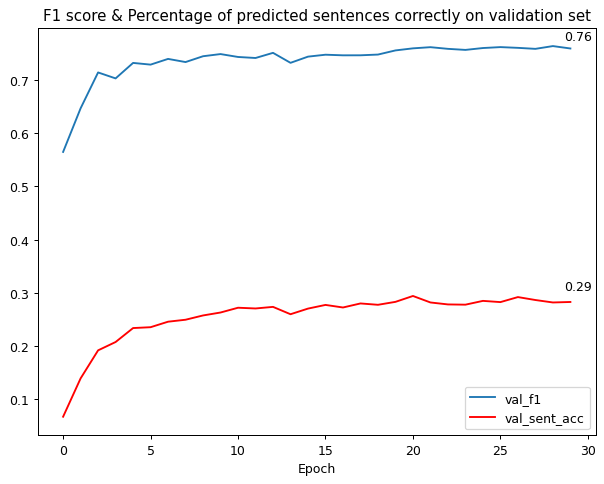

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 6), dpi=90)
val_f1_his = history['val_f1']
val_sen_acc_his = history['val_sent_acc']
plt.plot(np.arange(30),val_f1_his, label='val_f1')
plt.plot(np.arange(30),val_sen_acc_his,label='val_sent_acc',color = 'red')

for var in (val_f1_his, val_sen_acc_his):
    plt.annotate('%0.2f' % max(var), xy=(1, max(var)), xytext=(-25, 5), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')

plt.xlabel('Epoch')
# plt.ylabel('')
plt.title("F1 score & Percentage of predicted sentences correctly on validation set")
plt.legend()
plt.show()

In [ ]:
from torch.optim import Adam

model = lstm_crf(
    word_input_dim=len(corpus.word_field.vocab),
    word_embedding_dim=300,
    char_embedding_dim=50,
    char_input_dim=len(corpus.char_field.vocab),
    char_cnn_filter_num=5,
    char_cnn_kernel_size=3,
    lstm_hidden_dim=400,
    output_dim=len(corpus.tag_field.vocab),
    lstm_layers=2,
    char_emb_dropout=0.5,
    word_emb_dropout=0.5,
    cnn_dropout=0.0,
    lstm_dropout=0.0,
    fc_dropout=0.33,
    word_pad_idx=corpus.word_pad_idx,
    char_pad_idx=corpus.char_pad_idx,
    tag_pad_idx=corpus.tag_pad_idx,

    use_char= True
)

checkpoint = torch.load('model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
from sklearn.metrics import f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

def f1_positive(corpus, preds, y, full_report=True):
    index_o = corpus.tag_field.vocab.stoi["O"]
    index_pad = corpus.tag_pad_idx
    # take all labels except padding and "O"
    positive_labels = [i for i in range(len(corpus.tag_field.vocab.itos))
                       if i not in [index_pad, index_o]]

    flatten_pred = [pred for sent_pred in preds for pred in sent_pred]
    flatten_y = [tag for sent_tag in y for tag in sent_tag]

    if full_report:
        # take all names except padding and "O"
        positive_names = [corpus.tag_field.vocab.itos[i] for i in positive_labels]

        print(classification_report(
            y_true=flatten_y,
            y_pred=flatten_pred,
            labels=positive_labels,
            target_names=positive_names
        ))


    return f1_score(
        y_true=flatten_y,
        y_pred=flatten_pred,
        labels=positive_labels,
        average="micro"
    )
    

def sent_accuracy(preds, y):
    assert len(preds) == len(y)
    count = 0
    for i in range(len(preds)):
        if preds[i] == y[i]:
            count += 1

    return count / len(preds)



device = 'cuda'
model.to(device)
model.eval()
with torch.no_grad():
    loss_test = 0
    true_tags_test = []
    pred_tags_test = []
    test_iter = corpus.test_iter
    for batch in test_iter:
        words = batch.word.to(device)
        chars = batch.char.to(device)
        true_tags = batch.tag.to(device)
        
        pred_tags, batch_loss = model(words, chars, true_tags)
        
        pred_tags_test += pred_tags
        true_tags_test += [[tag for tag in sent_tag if tag != corpus.tag_pad_idx]
                            for sent_tag in true_tags.permute(1, 0).tolist()]

print('Percentage of predicted sentences correctly on testing data: ')
print(sent_accuracy(pred_tags_test, true_tags_test))
print('--------------------------------------------------------------')
f1_score = f1_positive(corpus ,pred_tags_test, true_tags_test)

Percentage of predicted sentences correctly on testing data: 
0.31731869137497143
--------------------------------------------------------------
               precision    recall  f1-score   support

I-PERFORMANCE       0.77      0.77      0.77     18594
    I-BATTERY       0.80      0.88      0.84     14060
    I-GENERAL       0.75      0.75      0.75     11830
   I-FEATURES       0.74      0.73      0.74     12416
    I-SER&ACC       0.77      0.72      0.75      7252
     I-CAMERA       0.78      0.87      0.82      6266
     I-DESIGN       0.75      0.73      0.74      3410
    B-GENERAL       0.76      0.74      0.75      3236
B-PERFORMANCE       0.72      0.69      0.71      2736
     I-SCREEN       0.71      0.64      0.67      2562
    B-BATTERY       0.81      0.82      0.82      2228
      I-PRICE       0.58      0.46      0.51      1888
   B-FEATURES       0.68      0.66      0.67      1646
     B-CAMERA       0.85      0.85      0.85      1234
    B-SER&ACC       0.70     